In [1]:
import numpy as np
import pandas as pd
import time
import cv2 
import torch
from torchvision import datasets,models,transforms,utils
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import os
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
from pyspark.ml.linalg import DenseVector
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType,FloatType,IntegerType,StructType
spark=SparkSession.builder.master("local").appName("大数据大作业-探索、填补缺失值").getOrCreate()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from pyspark.ml import feature as ft
# Enable Arrow support.
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "64")
# 搭一个spark的环境
sc=spark.sparkContext
sc

<SparkContext master=local appName=大数据大作业-探索、填补缺失值>

In [2]:
df_all_features=spark.read.csv("train_all_features_noPCA.csv",header=True)
# 把那些特征变成应有的类型
for column in df_all_features.columns[3:]:
    df_all_features=df_all_features.withColumn(column,df_all_features[column].cast(FloatType()))
column="product_id"
df_all_features=df_all_features.withColumn(column,df_all_features[column].cast(IntegerType()))
df_all_features.printSchema()


root
 |-- product_id: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- quantity: float (nullable = true)
 |-- favorite: float (nullable = true)
 |-- negative_info: float (nullable = true)
 |-- coner_numbers: float (nullable = true)
 |-- face_numbers: float (nullable = true)
 |-- face_x: float (nullable = true)
 |-- faces_y: float (nullable = true)
 |-- face_size: float (nullable = true)
 |-- keypoint: float (nullable = true)
 |-- contour_numbers: float (nullable = true)
 |-- h1: float (nullable = true)
 |-- h2: float (nullable = true)
 |-- h3: float (nullable = true)
 |-- s1: float (nullable = true)
 |-- s2: float (nullable = true)
 |-- s3: float (nullable = true)
 |-- v1: float (nullable = true)
 |-- v2: float (nullable = true)
 |-- v3: float (nullable = true)
 |-- text_regions: float (nullable = true)
 |-- 1: float (nullable = true)
 |-- 2: float (nullable = true)
 |-- 3: float (nul

In [3]:
print('Count of rows: {0}'.format(df_all_features.count()))
print('Count of distinct rows: {0}'.format(df_all_features.distinct().count()))

Count of rows: 8000
Count of distinct rows: 8000


In [4]:
# 观察缺失数据
missing=df_all_features.rdd.map(
    lambda row: (row['product_id'], sum([c == None for c in row]))
).collect()

观察缺失值的总个数

In [5]:
import pyspark.sql.functions as fn
data_missing_columns=df_all_features.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_all_features.columns
]).toPandas()
data_missing_columns

,product_id_missing,product_category_missing,brand_missing,price_missing,quantity_missing,favorite_missing,negative_info_missing,coner_numbers_missing,face_numbers_missing,face_x_missing,...,503_missing,504_missing,505_missing,506_missing,507_missing,508_missing,509_missing,510_missing,511_missing,512_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020625,0.020625,0.020625,...,0.020625,0.020625,0.020625,0.020625,0.020625,0.020625,0.020625,0.020625,0.020625,0.020625


In [6]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-bright")
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False  

In [7]:
def plot_hist(column_name):
    """绘制hist的函数，输入是一个列名，需要输出的标题，来看看有什么模式可以应用"""
    
    hists=df_all_features.select(column_name).dropna().rdd.flatMap(lambda row: row).collect()
    if len(hists)==0:
        print(column_name,"没有数据，无法计算频数直方图")
        return 
    fig = plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.hist(hists)
    ax.set_title(column_name+'频数直方图')
    plt.show();

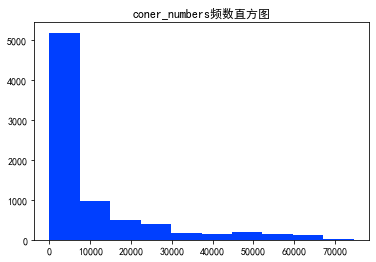

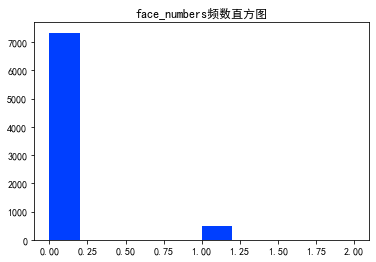

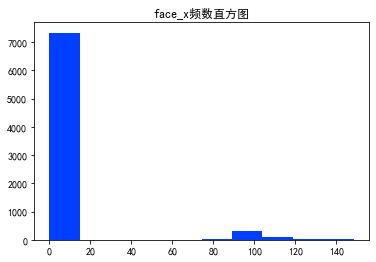

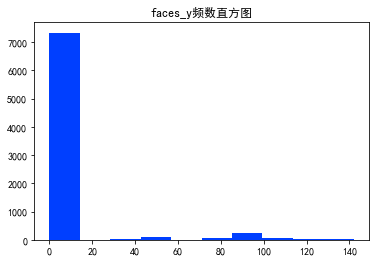

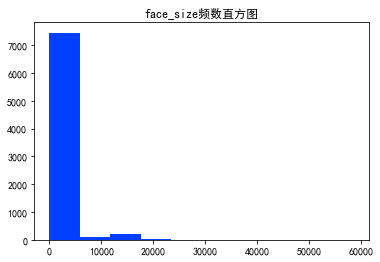

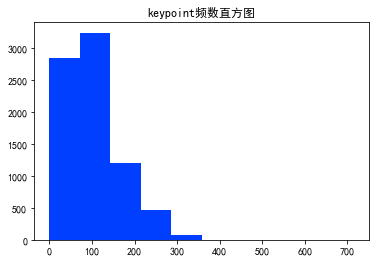

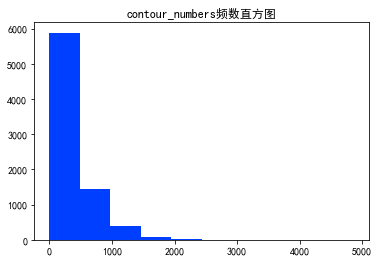

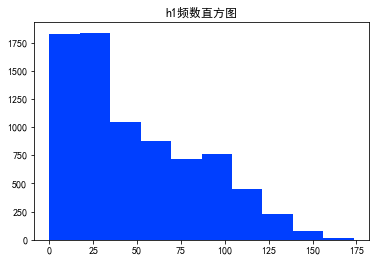

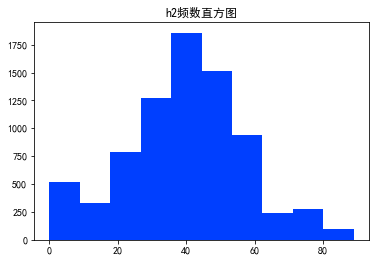

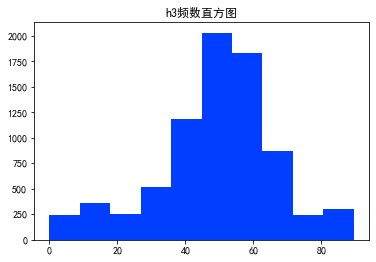

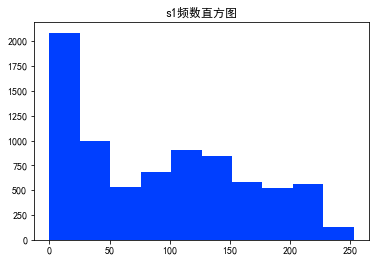

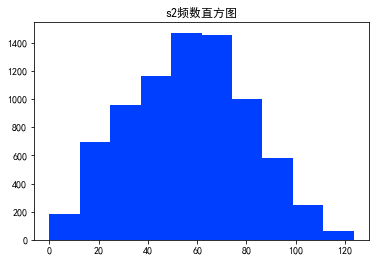

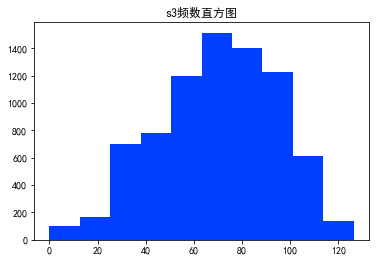

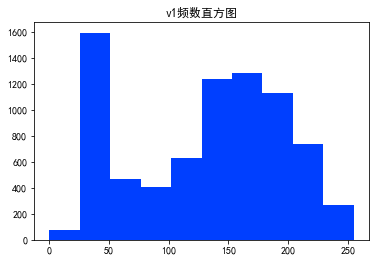

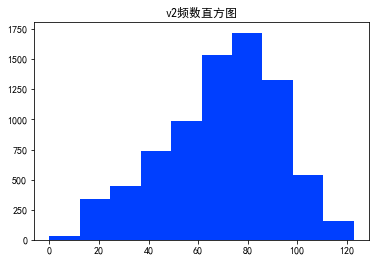

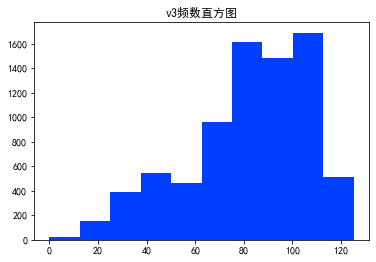

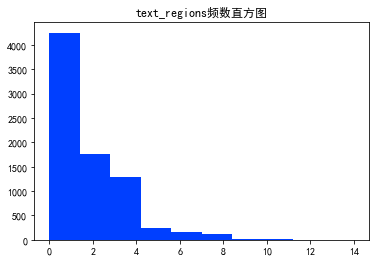

In [8]:
for column in df_all_features.columns[7:24]:
    plot_hist(column)

In [9]:
# 新增一个价格区间，按照1，2，3，4大致分四组
from pyspark.sql.functions import udf,log
hists=df_all_features.withColumn("price",log(df_all_features["price"]+1)).select("price").rdd.flatMap(
    lambda row:row
).histogram(3)
bound=np.exp(hists[0])*np.exp(-1)
def category(price):
    for i,b in enumerate(bound):
        if price<b:
            return i
    return len(bound)
category_udf=udf(category,IntegerType())
df_all_features_with_price_range=df_all_features.withColumn("price_range",category_udf("price"))
df_all_features_with_group=df_all_features_with_price_range.groupby("price_range")

# df_all_features_with_group.avg().show()

## 数据变成pandas
* 观察离群值
* 进行缺失值填补，使用sklearn

In [10]:
all_features=df_all_features.toPandas()
all_features_with_price_range=df_all_features_with_price_range.toPandas()

In [11]:
all_features_withoutnan=all_features.dropna()
all_features=all_features_withoutnan.copy()

In [12]:
# 首先对数据进行归一化
from sklearn import preprocessing
all_features.iloc[:,4:]=preprocessing.normalize(all_features.iloc[:,4:])
all_features.head()

,product_id,product_category,brand,price,quantity,favorite,negative_info,coner_numbers,face_numbers,face_x,...,503,504,505,506,507,508,509,510,511,512
0,1090,1,3,171.393997,0.000337,0.000000,0.0,0.993874,0.0,0.0,...,-0.000251,-0.000258,-0.000229,-0.000252,-0.000160,-0.000087,0.000689,-0.000023,0.000019,-0.000195
1,1159,1,3,98.383499,0.001661,0.309002,0.0,0.810715,0.0,0.0,...,-0.001239,-0.001272,-0.001129,-0.001240,-0.000927,-0.000897,-0.001281,-0.001293,-0.001174,-0.000961
2,1436,1,3,36.329601,0.001352,0.000000,0.0,0.939871,0.0,0.0,...,-0.001009,-0.001035,-0.000159,0.001375,-0.000860,-0.000730,-0.001042,-0.001053,-0.000955,0.000535
3,1512,1,5,20.985001,0.000071,0.000000,0.0,0.995789,0.0,0.0,...,-0.000012,0.000355,0.000087,-0.000025,-0.000045,-0.000038,-0.000055,-0.000055,-0.000050,0.000086
4,1572,1,3,168.205002,0.000324,0.000000,0.0,0.996682,0.0,0.0,...,-0.000241,-0.000248,-0.000220,-0.000242,-0.000206,0.000224,0.000472,0.000268,-0.000124,-0.000124


In [13]:
import seaborn as sns

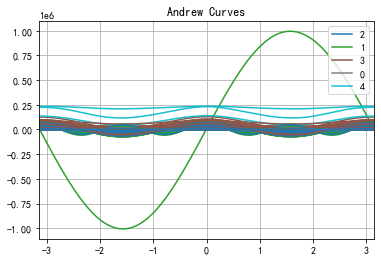

In [14]:
# 调和曲线图
figure=pd.plotting.andrews_curves(all_features_with_price_range.iloc[:,3:],class_column="price_range",colormap="tab10")
figure.set_title("Andrew Curves");

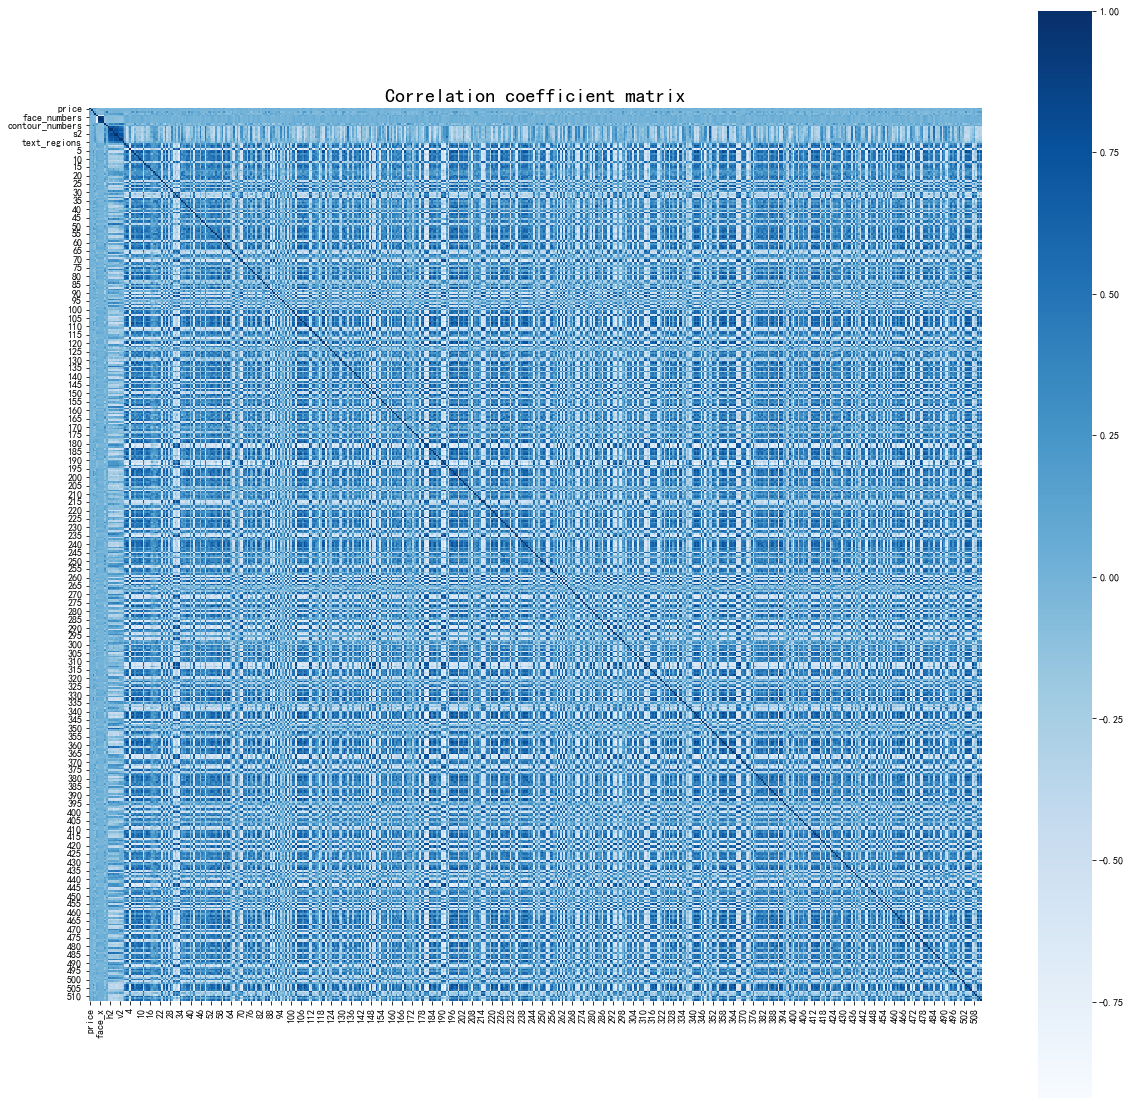

In [15]:
corr=all_features.iloc[:,3:].corr().dropna(axis=1,how="all").dropna(axis=0,how="all")
plt.figure(figsize=(20,20))
figure1=sns.heatmap(corr, vmax=1, square=True,cmap="Blues")
# #使用heatmap创建热图
figure1.set_title("Correlation coefficient matrix",
                  fontdict={'weight':'normal','size': 20});

In [17]:
all_features.to_csv("train_all_features_noPCA-2.csv")